In [1]:
this_notebook_name = "Segmentation3-QueensToChildrens_Grouped"

import datetime
import os 

import matplotlib.pyplot as plt
import numpy as np

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l1, l2

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from local_vars import root_folder

num_classes = 2
ultrasound_size = 128

# Input data folders and paths

train_data_folder = "LeaveOneOutTrainArrays"
val_data_folder   = "LeaveOneOutTestArrays"
test_data_folder  = "ChildrensTestArrays"

outList = [r"q000", r"q001", r"q002", r"q003", r"q004", r"q005", r"q006", r"q007"]

# Output folders

notebook_save_folder    = "LeaveOneOutNotebooks"
model_save_folder       = "LeaveOneOutModels"
test_predictions_folder = "ChildrensPredictionArrays"

# Augmentation parameters

max_rotation_angle = 10

# Model parameters

filter_multiplier = 10

# Learning parameters

num_epochs = 100
batch_size = 24
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
WCE_weights = np.array([0.05, 0.95])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Other parameters

num_show = 2

Using TensorFlow backend.


In [2]:
# Data importing function

def get_data(root_folder, data_folder, ultrasound_file, segmentation_file):
    data_fullpath = os.path.join(root_folder, data_folder)

    ultrasound_fullname = os.path.join(data_fullpath, ultrasound_file)
    segmentation_fullname = os.path.join(data_fullpath, segmentation_file)

    ultrasound_data = np.load(ultrasound_fullname)
    segmentation_data = np.load(segmentation_fullname)

    return ultrasound_data, segmentation_data, data_fullpath

In [3]:
# Create Ultrasound Segmentation Batch Generator Class
import keras.utils
import scipy.ndimage

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(ultrasound_size, ultrasound_size),
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))
        
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2)
            if flip_flag == 1:
                x[i,:,:,:] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
                y[i,:,:] = np.flip(self.y[batch_indexes[i],:,:], axis=1)
            else:
                x[i,:,:,:] = self.x[batch_indexes[i],:,:,:]
                y[i,:,:] = self.y[batch_indexes[i],:,:]
        
        angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (1,2), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(y, angle, (1,2), False, mode="constant", cval=0, order=0)
        
        x_rot = np.clip(x_rot, 0.0, 1.0)
        y_rot = np.clip(y_rot, 0.0, 1.0)
        
        y_onehot = keras.utils.to_categorical(y_rot, self.n_classes)
        
        return x_rot, y_onehot

In [4]:
def dialateStack(segmentation_data, iterations):
    
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

In [5]:
# U-Net Model Construction
from keras import backend as K

def nvidia_unet(patch_size=ultrasound_size, num_classes=num_classes, regularization_rate=0.):
    input_ = Input((patch_size, patch_size, 1))
    skips = []
    output = input_
    
    num_layers = int(np.floor(np.log2(patch_size)))
    down_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    down_filter_numbers = np.zeros([num_layers], dtype=int)
    up_conv_kernel_sizes = np.zeros([num_layers], dtype=int)
    up_filter_numbers = np.zeros([num_layers], dtype=int)
    
    for layer_index in range(num_layers):
        down_conv_kernel_sizes[layer_index] = int(3)
        down_filter_numbers[layer_index] = int( (layer_index + 1) * filter_multiplier + num_classes )
        up_conv_kernel_sizes[layer_index] = int(4)
        up_filter_numbers[layer_index] = int( (num_layers - layer_index - 1) * filter_multiplier + num_classes )
    
    for shape, filters in zip(down_conv_kernel_sizes, down_filter_numbers):
        skips.append(output)
        output = Conv2D(filters, (shape, shape), strides=2, padding="same", activation="relu", bias_regularizer=l1(regularization_rate))(output)
    
    for shape, filters in zip(up_conv_kernel_sizes, up_filter_numbers):
        output = keras.layers.UpSampling2D()(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=3)
        if filters != num_classes:
            activation = "relu"
            output = Conv2D(filters, (shape, shape), activation="relu", padding="same", bias_regularizer=l1(regularization_rate))(output)
            output = BatchNormalization(momentum=.9)(output)
        else:
            activation = "softmax"
            output = Conv2D(filters, (shape, shape), activation="softmax", padding="same", bias_regularizer=l1(regularization_rate))(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    """
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        
        return loss
    
    return loss

#############################################
Training network that leaves out q000
#############################################

val_acc: 0.9921376052356902 val loss: 0.0027061531353475793 val_dice: 0.9958340894608271
Total training time: 0:17:28.454581

Validation predictions saved to: d:\Data\LeaveOneOutTestArrays\q000_prediction.npy

Testing predictions saved to:    d:\Data\ChildrensTestArrays\q000_prediction.npy

Model saved to: d:\Data\LeaveOneOutModels\model_2019-10-12_13-42-18.h5

#############################################
Training network that leaves out q001
#############################################

val_acc: 0.9956991970539093 val loss: 0.0043027792458555526 val_dice: 0.9976565752710614
Total training time: 0:18:31.291595

Validation predictions saved to: d:\Data\LeaveOneOutTestArrays\q001_prediction.npy

Testing predictions saved to:    d:\Data\ChildrensTestArrays\q001_prediction.npy

Model saved to: d:\Data\LeaveOneOutModels\model_2019-10-12_14-00-53.h5

##########

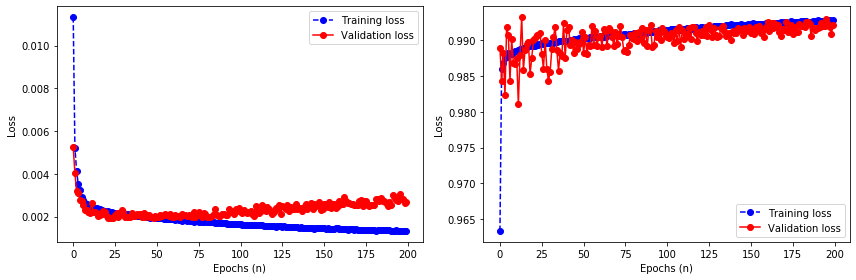

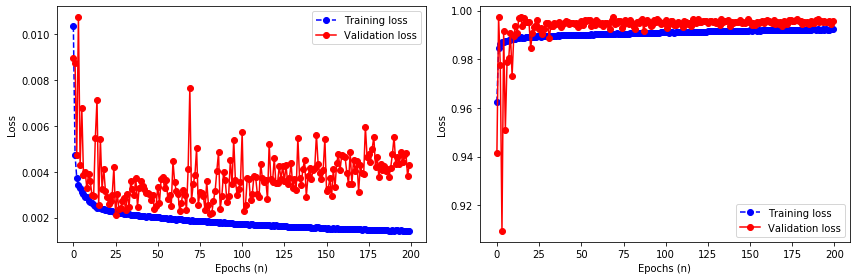

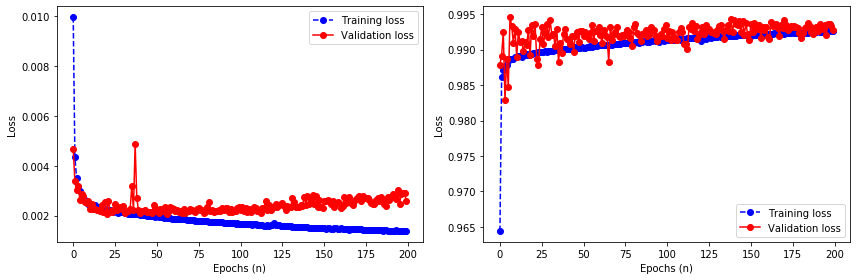

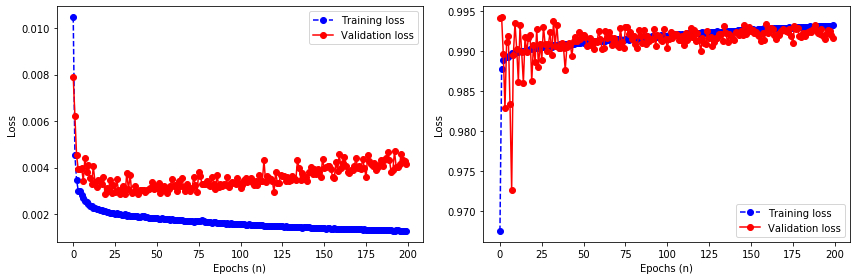

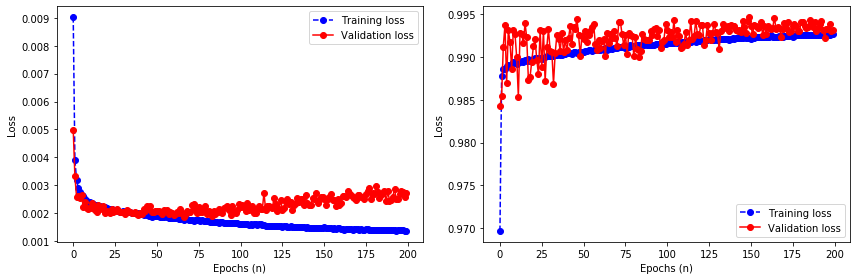

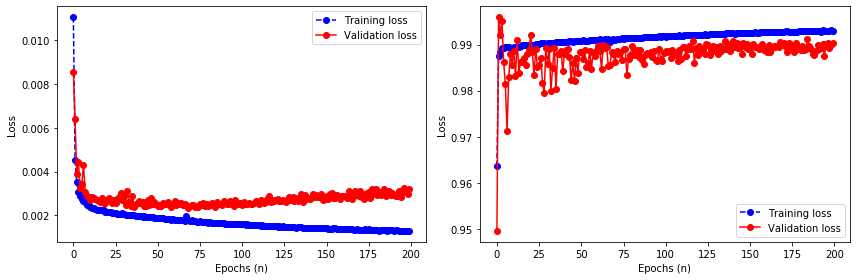

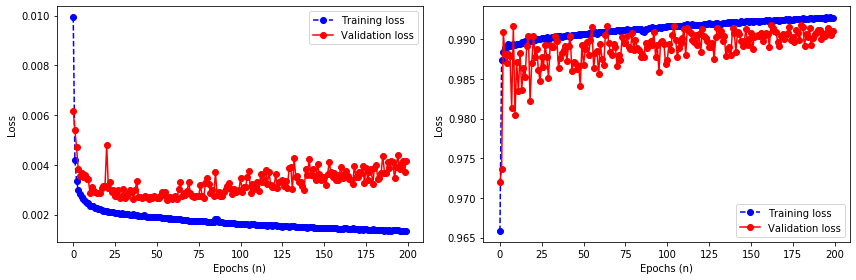

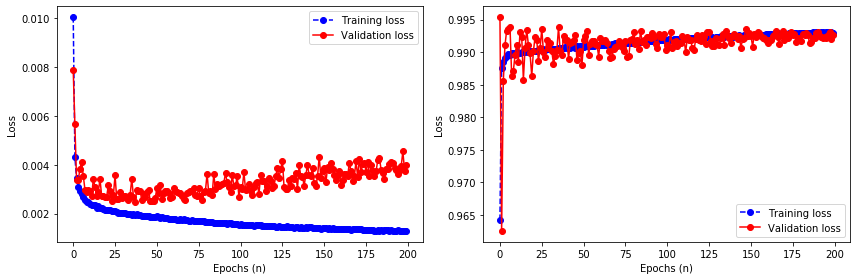

In [6]:
time_sequence_start = datetime.datetime.now()

for out in outList:
    #
    # Add in Children's Predictions at the same time (so we're using the same model for both)
    #
    train_ultrasound_file = out + r"out_ultrasound.npy"
    train_segmentation_file = out + r"out_segmentation.npy"

    # Get Leave Out One Filenames
    val_ultrasound_file = out + r"_ultrasound.npy"
    val_segmentation_file = out + r"_segmentation.npy"
    val_prediction_file = out + r"_prediction.npy"
    
    # Get Childrens Test Filenames
    test_ultrasound_file = r"ultrasound-test.npy"
    test_segmentation_file = r"segmentation-test.npy"
    test_prediction_file = out + r"_prediction.npy"
    
    print("#############################################")
    print("Training network that leaves out", out)
    print("#############################################\n")
    
    # Load data for training, validation, and testing
    
    train_ultrasound_data, train_segmentation_data, train_data_fullpath =\
        get_data(root_folder, train_data_folder, train_ultrasound_file, train_segmentation_file)
    
    val_ultrasound_data, val_segmentation_data, val_data_fullpath =\
        get_data(root_folder, val_data_folder, val_ultrasound_file, val_segmentation_file)
    
    test_ultrasound_data, test_segmentation_data, test_data_fullpath =\
        get_data(root_folder, test_data_folder, test_ultrasound_file, test_segmentation_file)
    
    # Create and train model
    
    model = nvidia_unet(ultrasound_size, num_classes, regularization_rate)
    model.compile(optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
              loss=[weighted_categorical_crossentropy(WCE_weights)],
              metrics=["accuracy", dice_coef])
    
    training_generator = UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data, train_segmentation_data[:, :, :, 0], batch_size)
    
    validation_generator = UltrasoundSegmentationBatchGenerator(
        val_ultrasound_data, val_segmentation_data[:, :, :, 0], batch_size)
    
    test_generator = UltrasoundSegmentationBatchGenerator(
        test_ultrasound_data, test_segmentation_data[:, :, :, 0], batch_size)
    
    training_time_start = datetime.datetime.now()
    
    training_log = model.fit_generator(training_generator,
                                       validation_data=validation_generator,
                                       epochs=num_epochs,
                                       verbose=0)
        
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("val_acc:", training_log.history['val_acc'][-1], "val loss:", training_log.history['val_loss'][-1], "val_dice:", training_log.history['val_dice_coef'][-1])
    print("Total training time: {}\n".format(training_time_stop-training_time_start))
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['acc'], 'bo--')
    axes[1].plot(training_log.history['val_acc'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Loss')
    axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Predict on Test Data
    
    y_pred_val  = model.predict(val_ultrasound_data)
    y_pred_test = model.predict(test_ultrasound_data)
    
    # Saving L-1-O prediction for further evaluation
    
    val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_file)
    np.save(val_prediction_fullname, y_pred_val)
    print("Validation predictions saved to: {}\n".format(val_prediction_fullname))

    # Saving test prediction for further evaluation
    
    if not os.path.exists(test_predictions_folder):
        os.makedirs(test_predictions_folder)
        print("Creating folder: {}".format(test_predictions_folder))
    
    test_prediction_fullname = os.path.join(test_predictions_folder, test_prediction_file)
    np.save(test_prediction_fullname, y_pred_test)
    print("Testing predictions saved to:    {}\n".format(test_prediction_fullname))
    
    # Archive model and notebook with unique filenames based on timestamps
    
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    saved_models_fullpath = os.path.join(root_folder, model_save_folder)
    if not os.path.exists(saved_models_fullpath):
        os.makedirs(saved_models_fullpath)
        print("Creating folder: {}".format(saved_models_fullpath))
    model_file_name = "model_" + timestamp + ".h5"
    model_fullname = os.path.join(saved_models_fullpath, model_file_name)
    model.save(model_fullname)
    print("Model saved to: {}\n".format(model_fullname))


time_sequence_stop = datetime.datetime.now()

print("\nTraining started at: {}".format(time_sequence_start))
print("Training stopped at:   {}".format(time_sequence_stop))
print("Total training time:   {}".format(time_sequence_stop - time_sequence_start))
    

In [7]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [8]:
# Export HTML copy of this notebook

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
saved_notebooks_fullpath = os.path.join(root_folder, notebook_save_folder)
if not os.path.exists(saved_notebooks_fullpath):
    os.makedirs(saved_notebooks_fullpath)
    print("Creating folder: {}".format(saved_notebooks_fullpath))

notebook_file_name = this_notebook_name + "_" + timestamp + ".html"
notebook_fullname = os.path.join(saved_notebooks_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: d:\Data\LeaveOneOutNotebooks\Segmentation3-QueensToChildrens_Grouped_2019-10-12_15-52-57.html
